# Time Series Analysis and Forecasting

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
#there are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.
df = pd.read_excel(r'C:\Users\GLORY COMPUTERS\Documents\datasets\superstore.xls')
furniture = df.loc[df['Category'] == 'Furniture']

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

**Data Preprocessing**

In [5]:
#this step includes removing columns not needed, checking missing values, aggregating sales by date, etc.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [6]:
#indexing with time series data
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [7]:
#our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using 
#the start of each month as the timestamp.
y = furniture['Sales'].resample('MS').mean()


#have a quick peek 2017 furniture sales data.
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

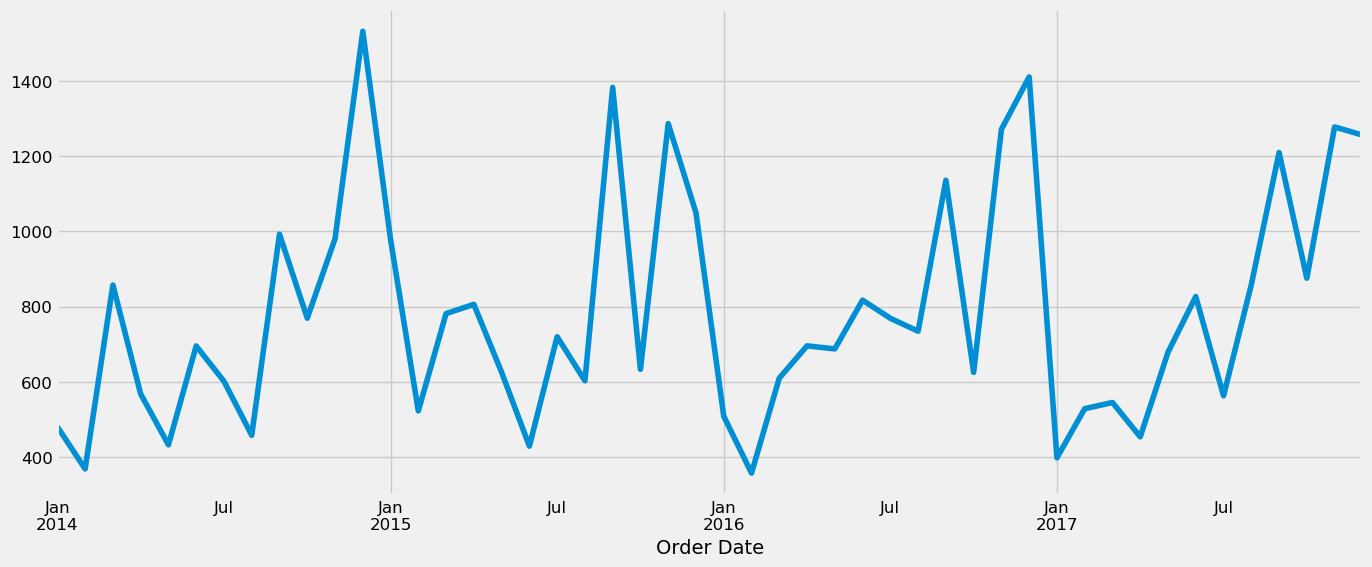

In [8]:
#visualizing furniture sales time series data
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

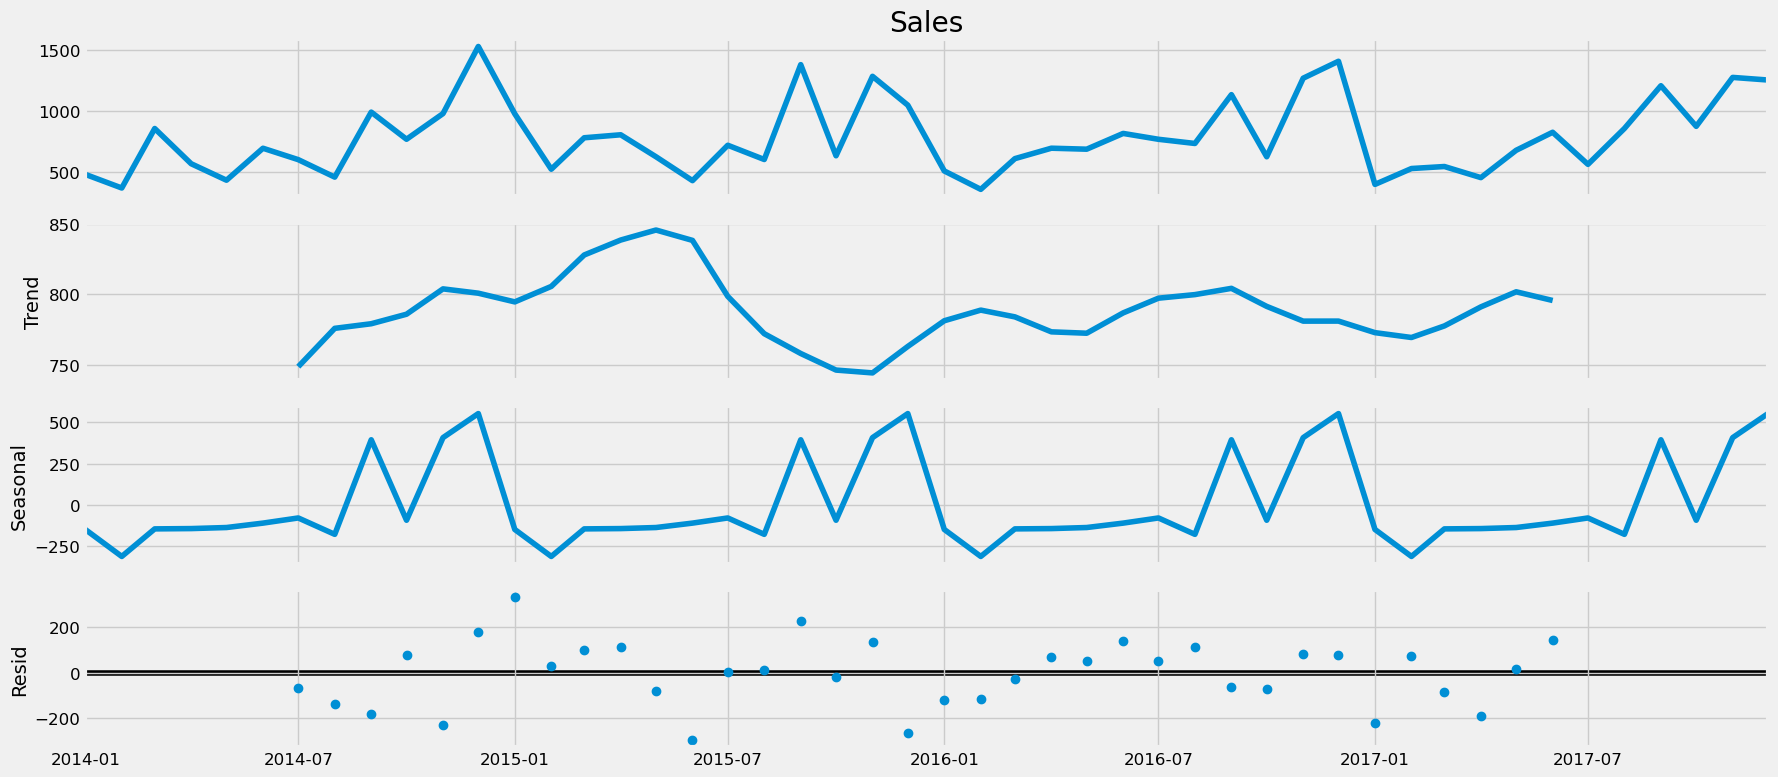

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

**Time series forecasting with ARIMA**
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

In [10]:
#ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Grid search for the best ARIMA model
best_aic = float("inf")
best_param = None
best_param_seasonal = None
best_results = None

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
#this step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of 
#parameters that yields the best performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)  # Set disp=False to suppress fit output
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal
                best_results = results
                
        except Exception as e:
            print(f'Error fitting ARIMA{param}x{param_seasonal}12: {e}')
            continue

print(f'\nBest ARIMA model: ARIMA{best_param}x{best_param_seasonal}12 - AIC:{best_aic}')

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1567.4749364167214
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793568
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:478.27925331444305
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803027265
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758109
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2792.7305904497425
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809151
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673286
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5910637670013
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:467.5616452328524
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576520697
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1702.9809434449971
ARIM

The above output suggests that SARIMAX(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 279.58. Therefore we should consider this to be optimal option.

In [14]:
#fitting the ARIMA model
#enforce_stationarity=False
mod = sm.tsa.statespace.SARIMAX(y,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1061.683     -0.001      0.999   -2081.861    2079.861
ma.S.L12      -1.0001   1061.749     -0.001      0.999   -2081.989    2079.989
sigma2      2.686e+04      0.002   1.54e+07      0.000    2.69e+04    2.69e+04


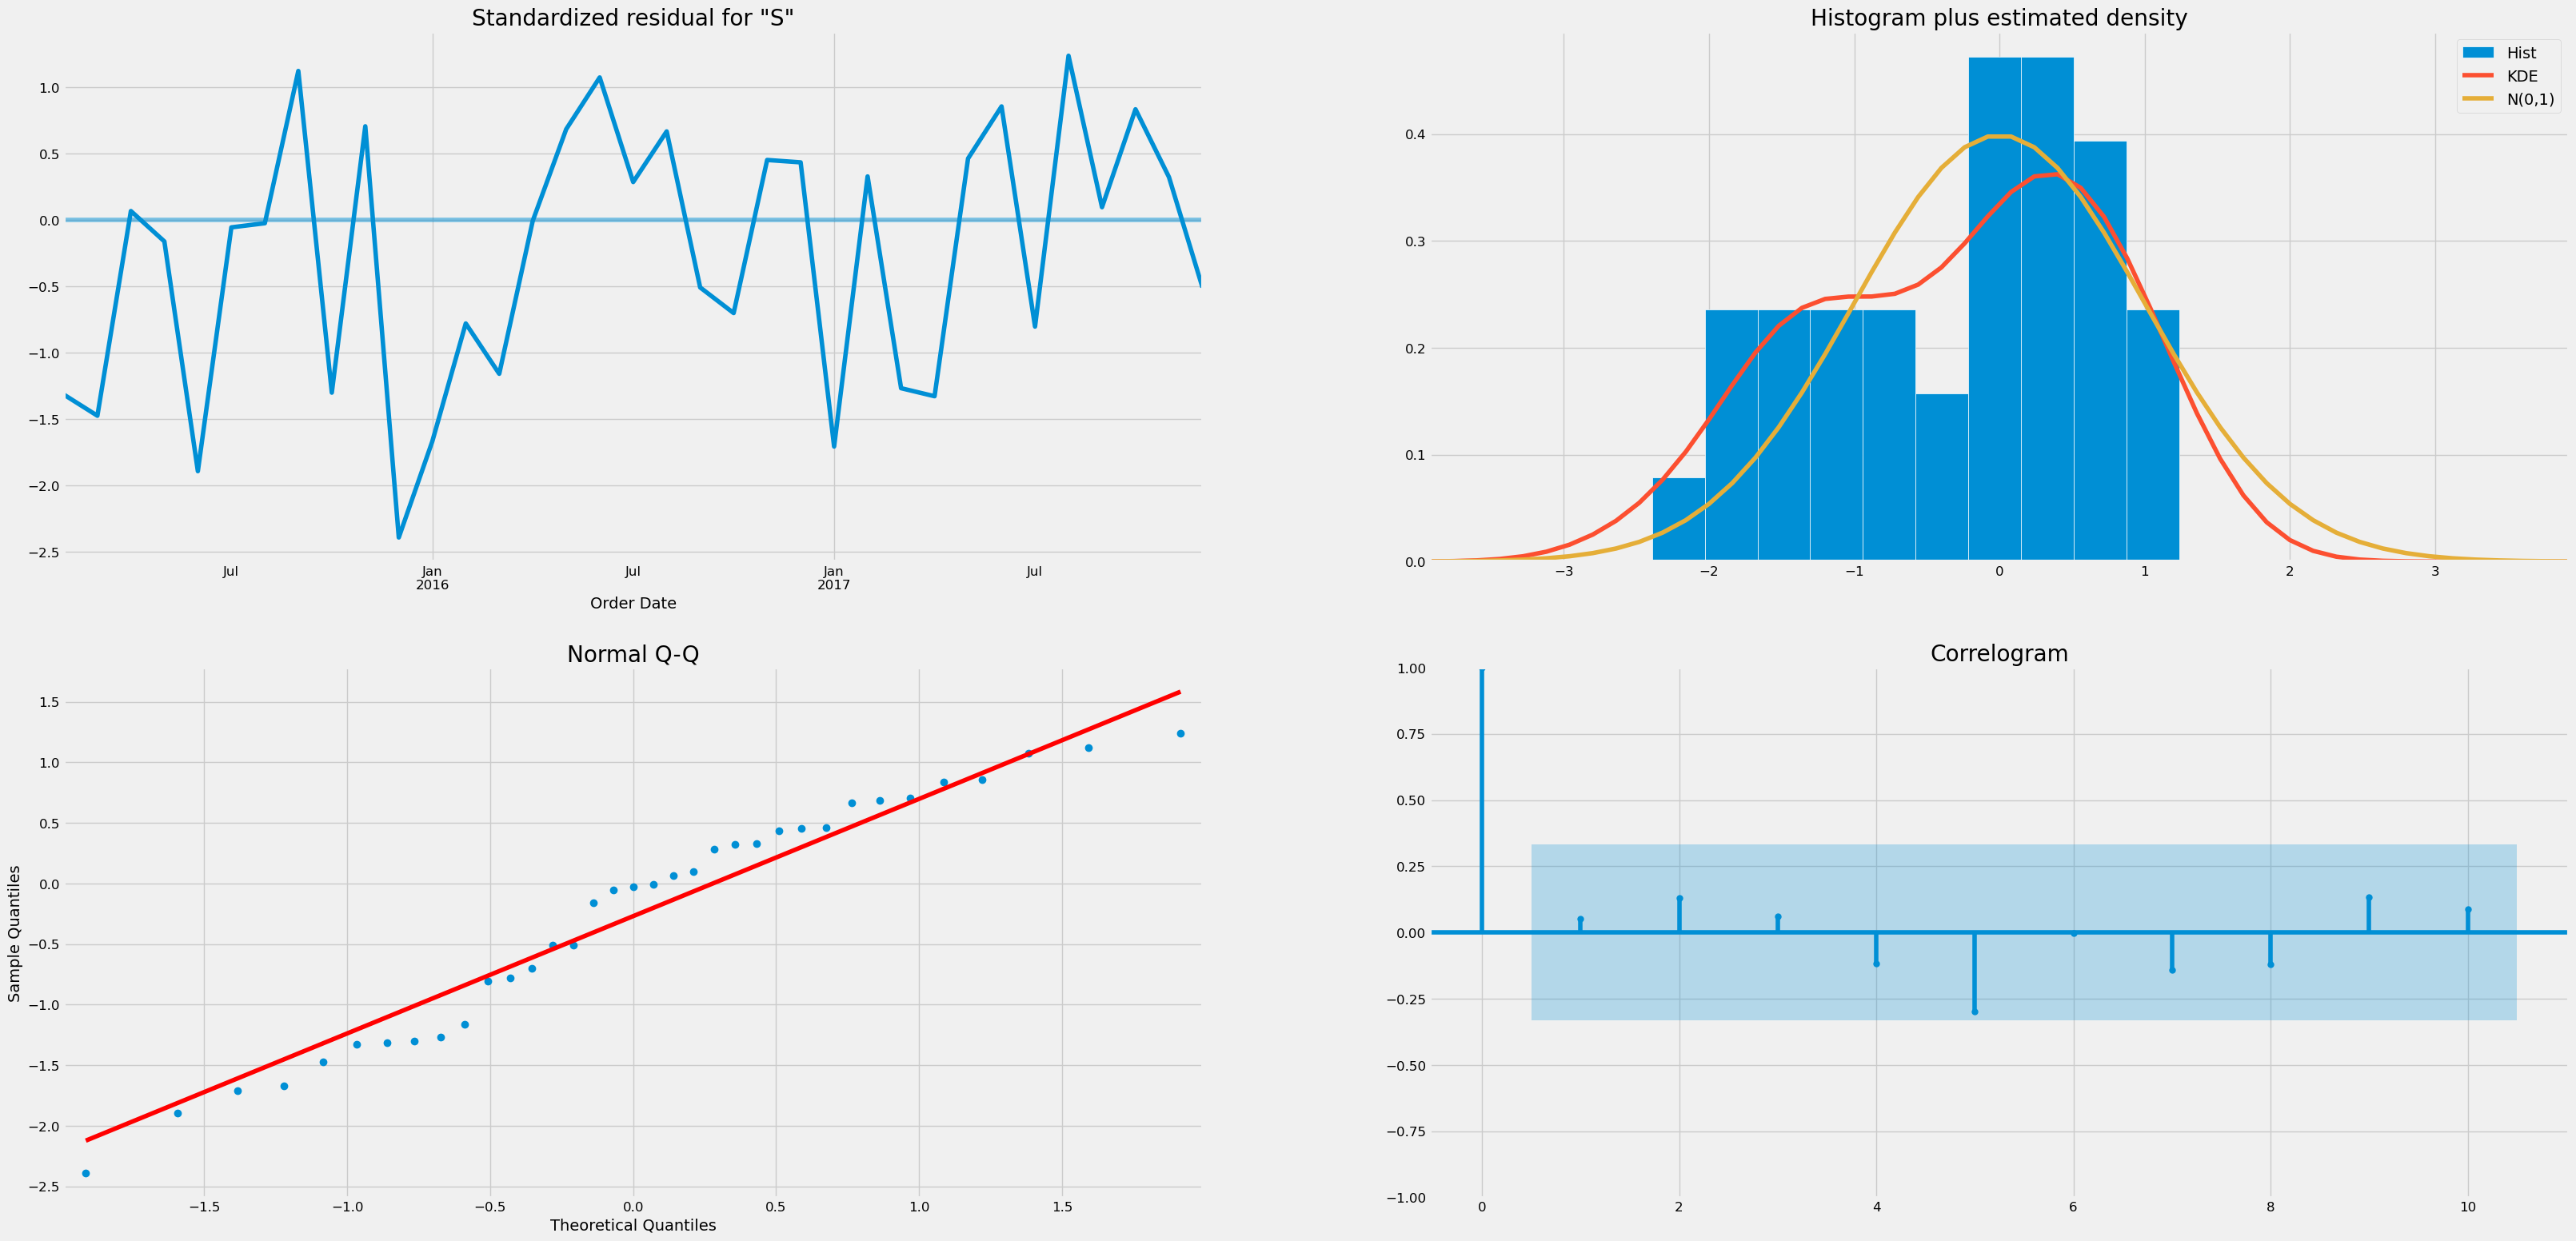

In [18]:
#we should always run model diagnostics to investigate any unusual behavior.
results.plot_diagnostics(figsize=(36, 18))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

**Validating forecasts**

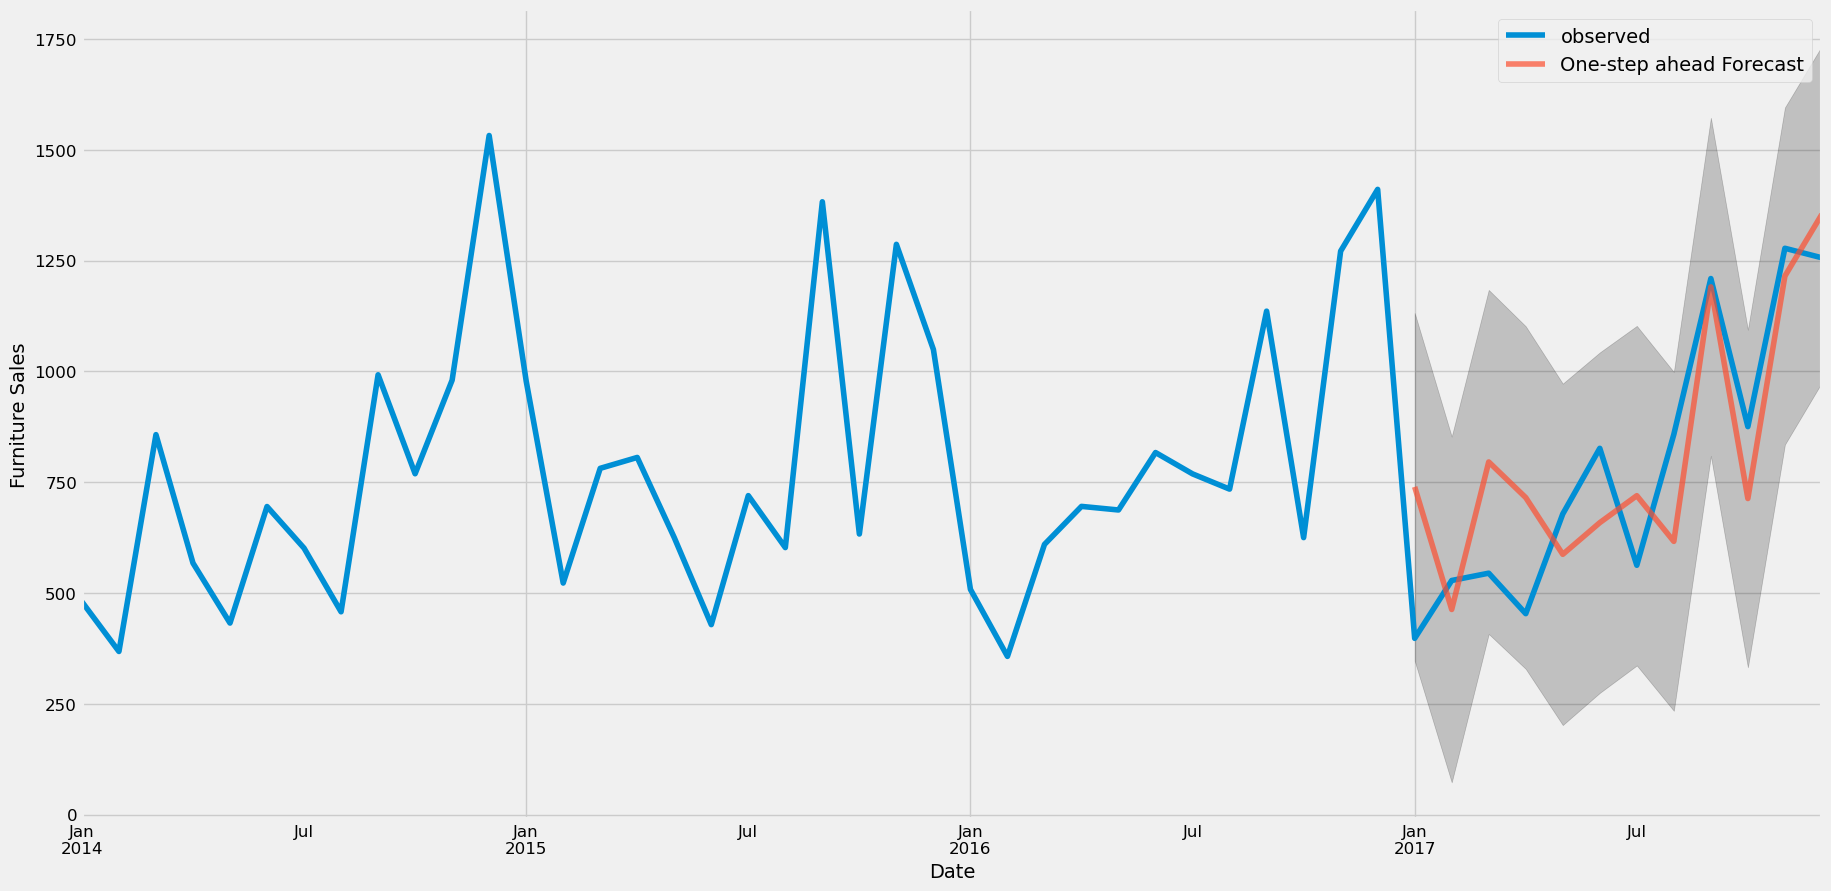

In [20]:
#to help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34370.12


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 185.39


The mean squared error (MSE) of an estimator measures the average of the squares of the errors, that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 185.39 of the real sales. Our furniture daily sales range from around 400 to over 1200.

**Producing and Visualizing Forecasts**

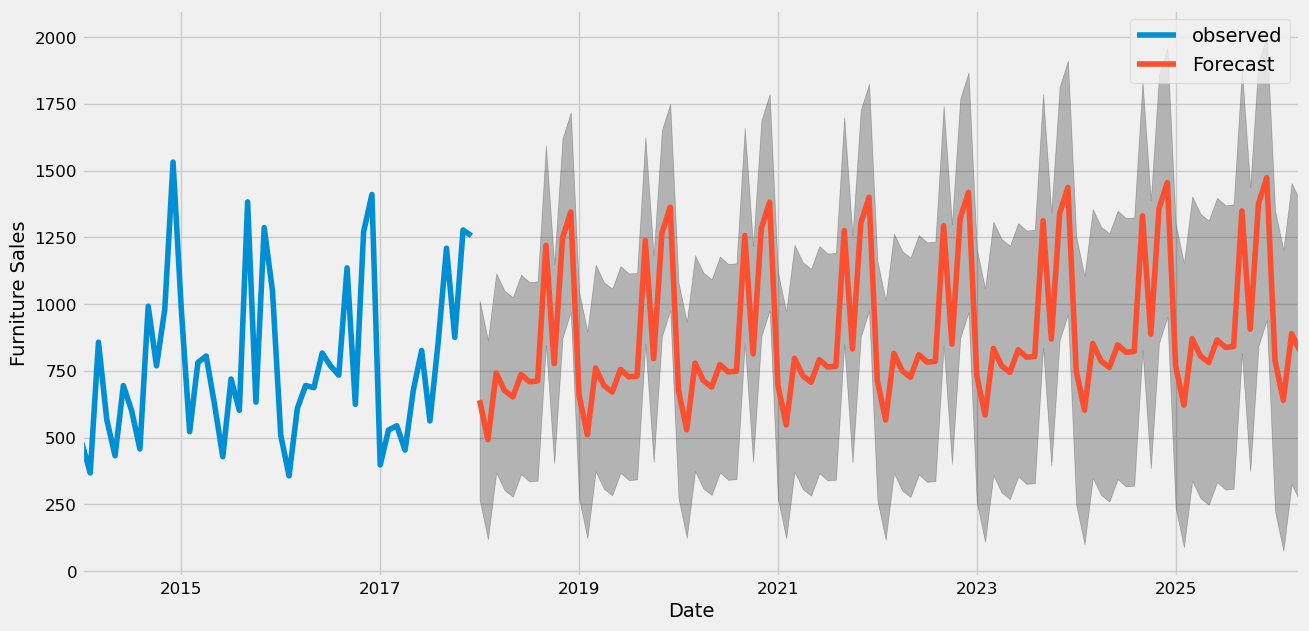

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

This model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture spikes my curiousity about other categories and how they compare to each other over time.

**Time Series of Furniture vs. Office Supplies**

In [24]:
#aAccording to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [25]:
#we are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


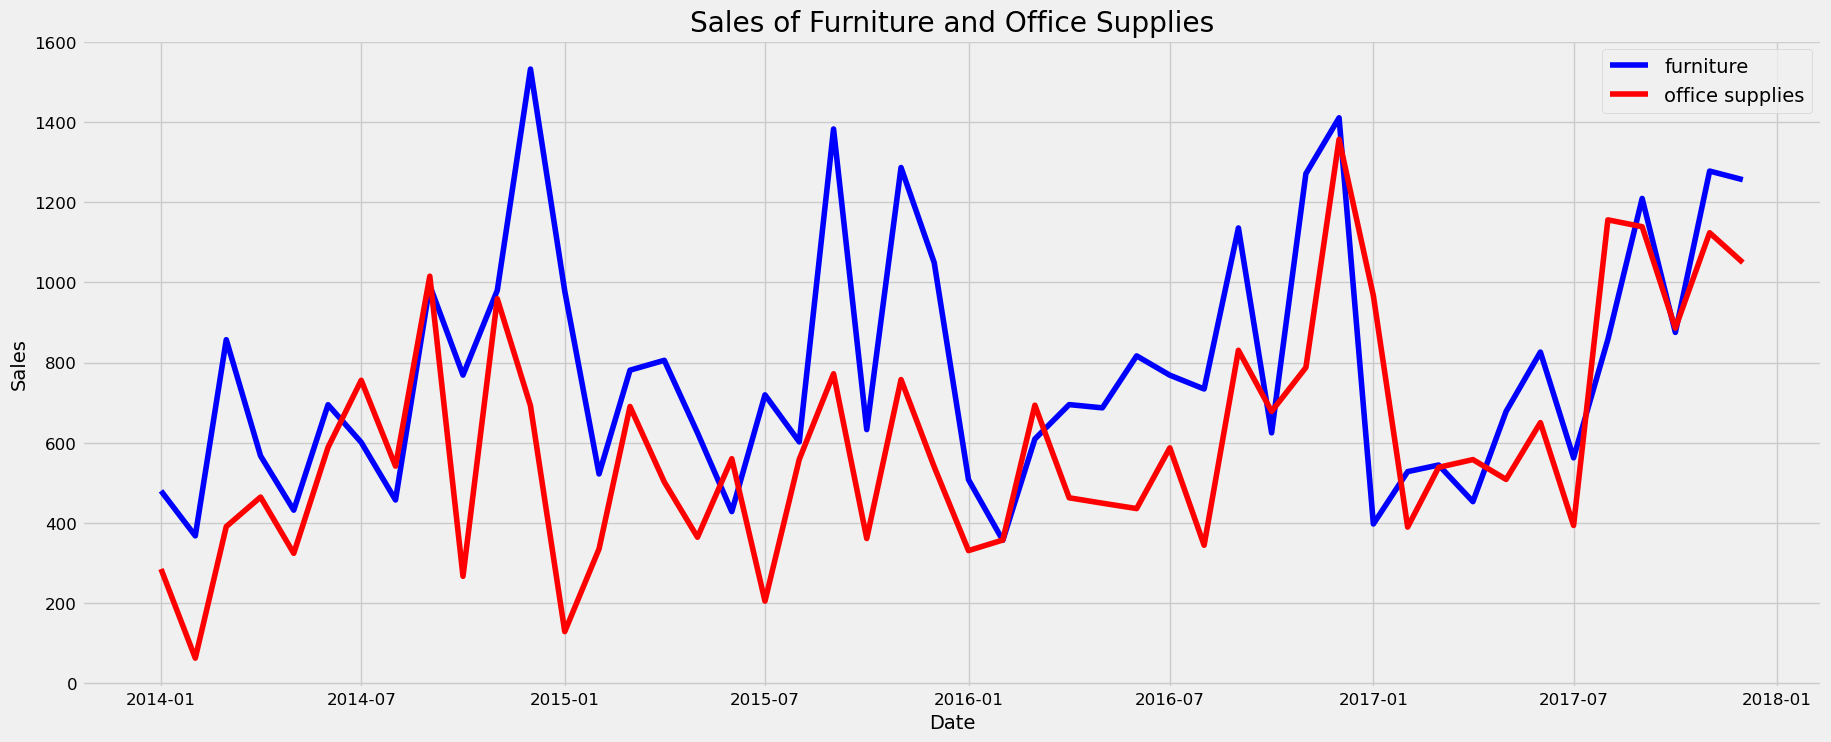

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that the sales of furniture and office supplies share a similar seasonal pattern. Early in the year is the off-season for both categories. It seems that summer time is also quiet for office supplies. Additionally, average daily sales for furniture are higher than those of office supplies in most months. This is understandable, as the value of furniture is typically much higher than that of office supplies. Occasionally, office supplies surpassed furniture in average daily sales. Let’s find out when office supplies' sales first exceeded those of furniture.

In [30]:
first_date_index = np.where(store['office_sales'] > store['furniture_sales'])[0][0]
first_date = store.iloc[first_date_index]['Order Date']
print("Office supplies first time produced higher sales than furniture in {}.".format(first_date.date()))


Office supplies first time produced higher sales than furniture in 2014-07-01.


**Time Series Modeling with Prophet**

14:51:54 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 2400x800 with 0 Axes>

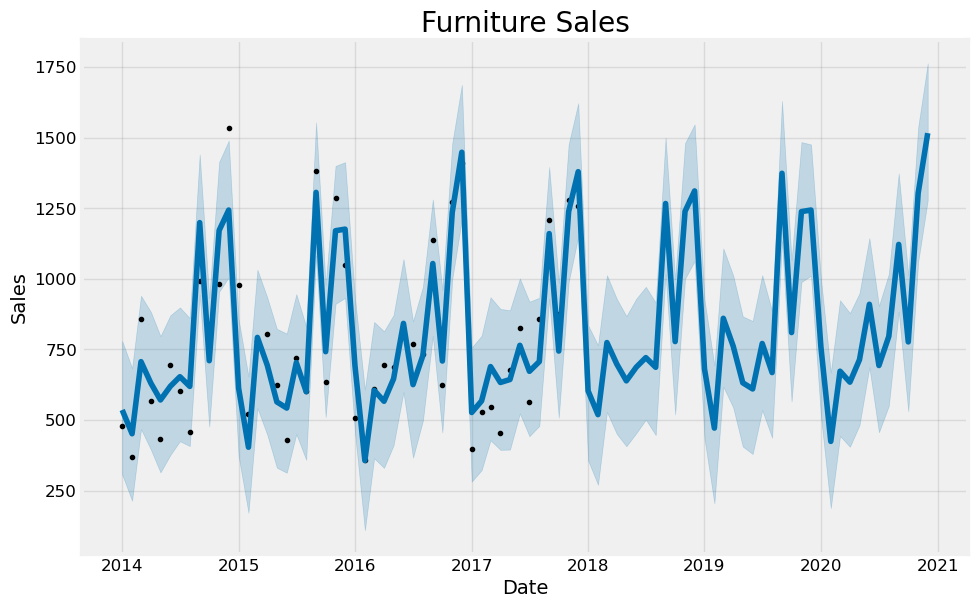

In [34]:
#released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

from prophet import Prophet
import matplotlib.pyplot as plt

#rename columns as required by Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

#create and fit the Prophet models
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office_model = Prophet(interval_width=0.95)
office_model.fit(office)

#make future predictions
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

#plot the results
plt.figure(figsize=(24, 8))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 2400x800 with 0 Axes>

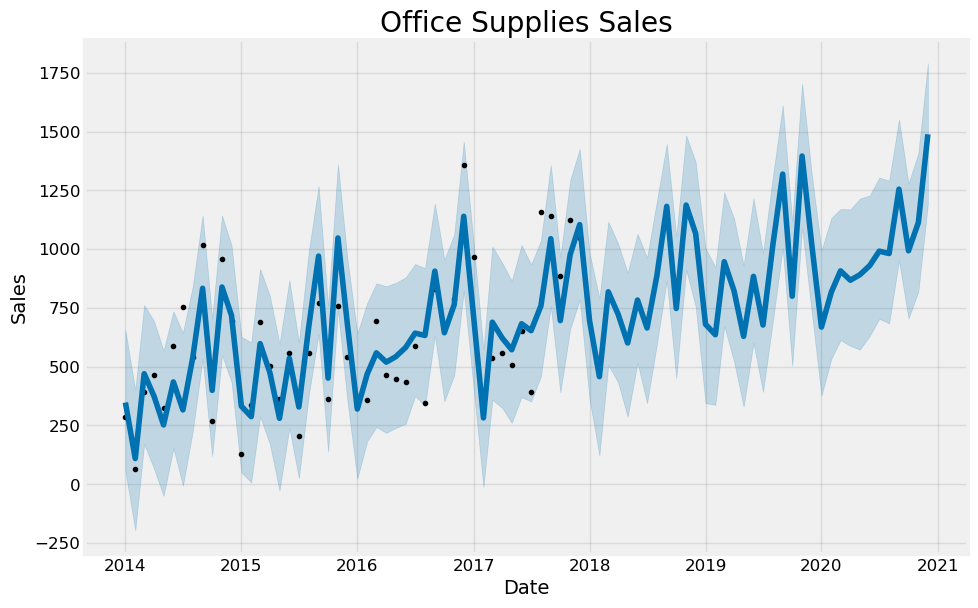

In [35]:
plt.figure(figsize=(24, 8))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

**Compare Forecasts**

In [36]:
#we already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,306.618186,779.613656,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,213.906225,683.528945,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,467.547505,939.877057,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,394.759716,882.332504,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,314.144822,796.737645,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


**Trend and Forecast Visualization**

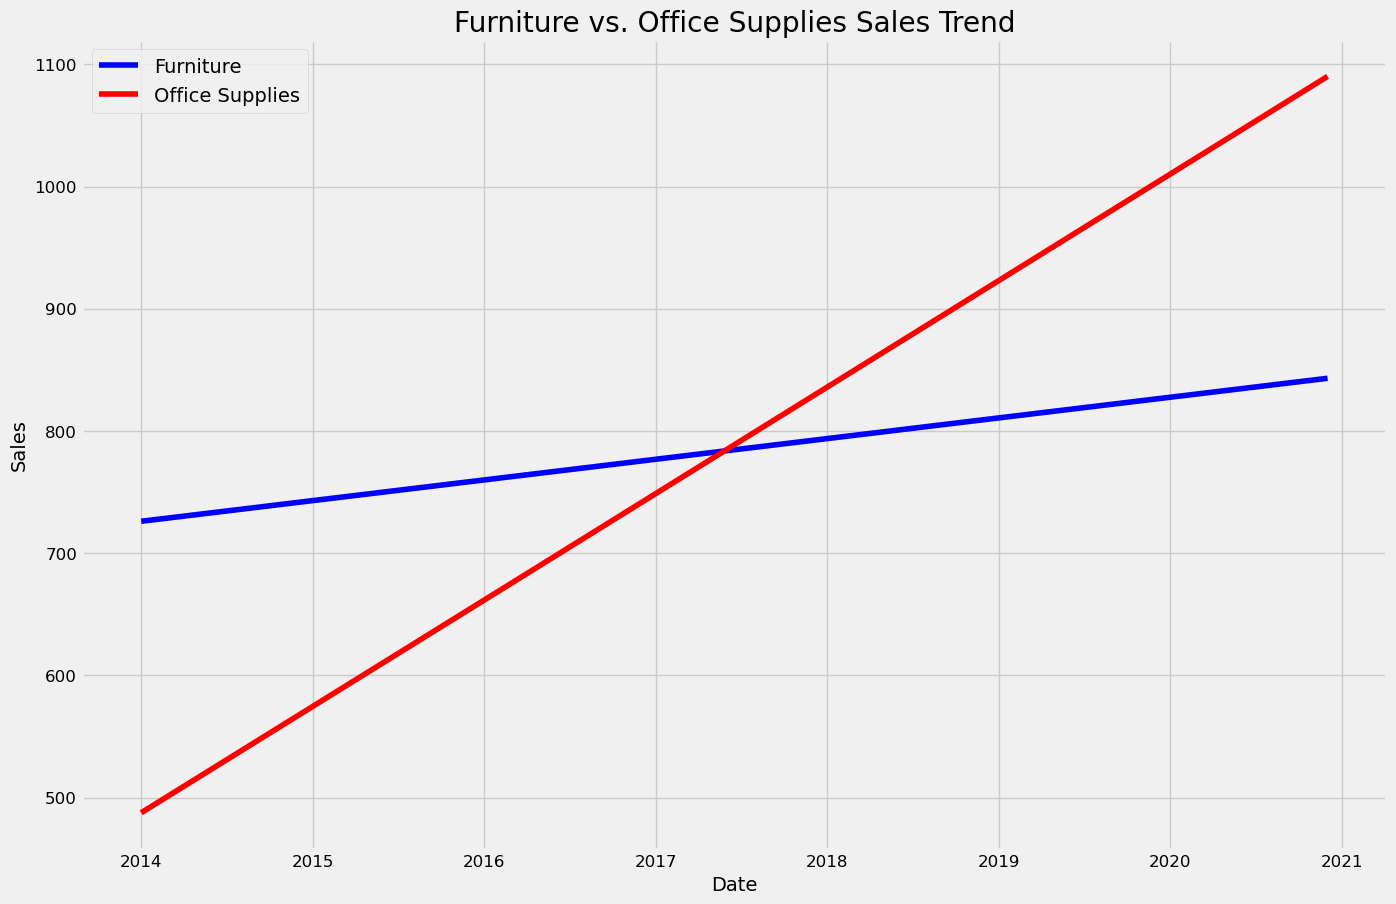

In [40]:
plt.figure(figsize=(15, 10))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label='Furniture')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-', label='Office Supplies')

#adding labels and title
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')

plt.show()

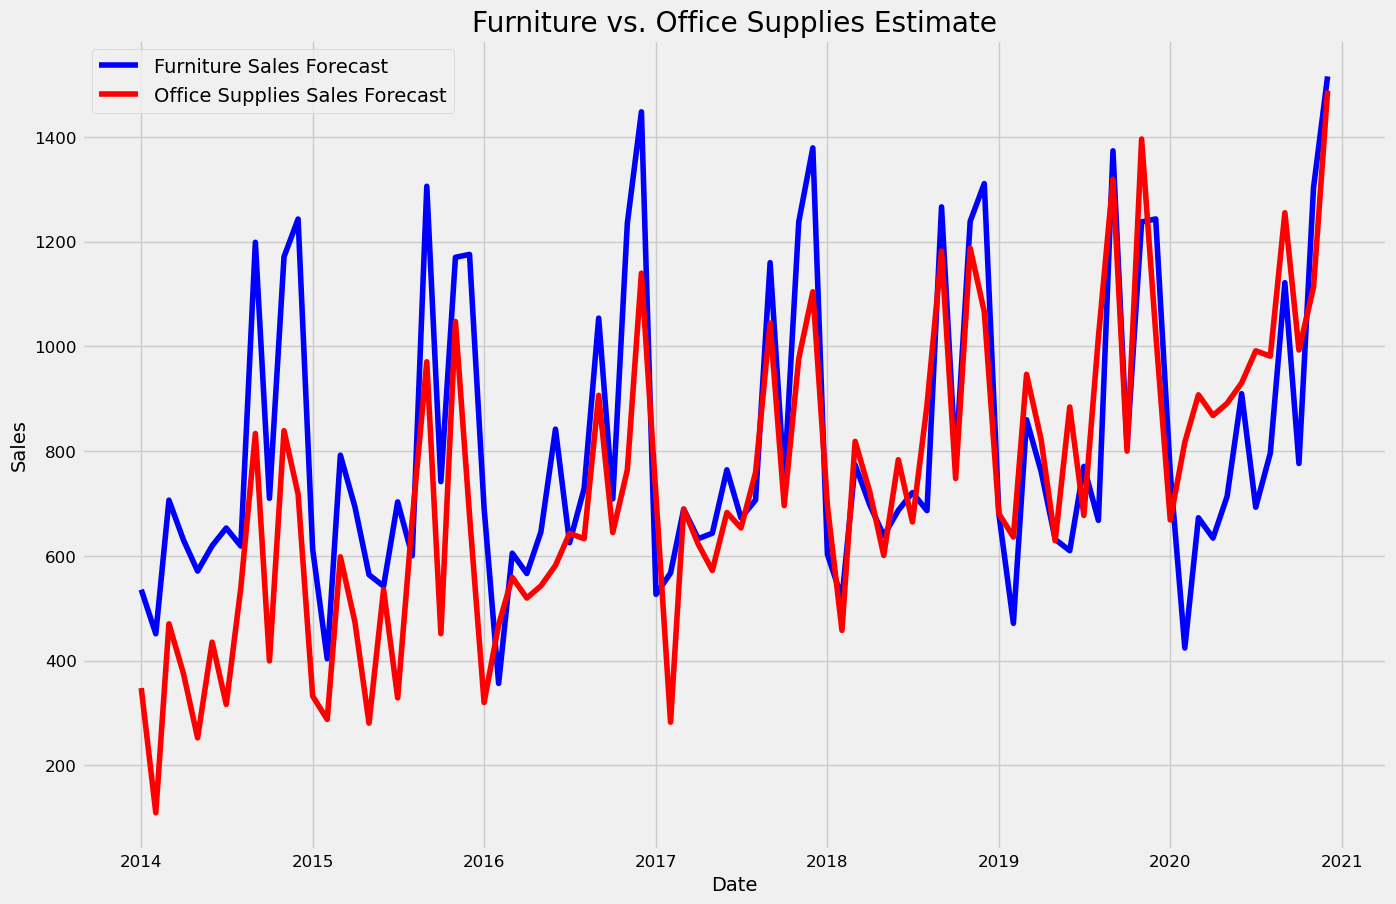

In [42]:
plt.figure(figsize=(15,10))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label='Furniture Sales Forecast')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-', label='Office Supplies Sales Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')
plt.show()

**Trends and Patterns**

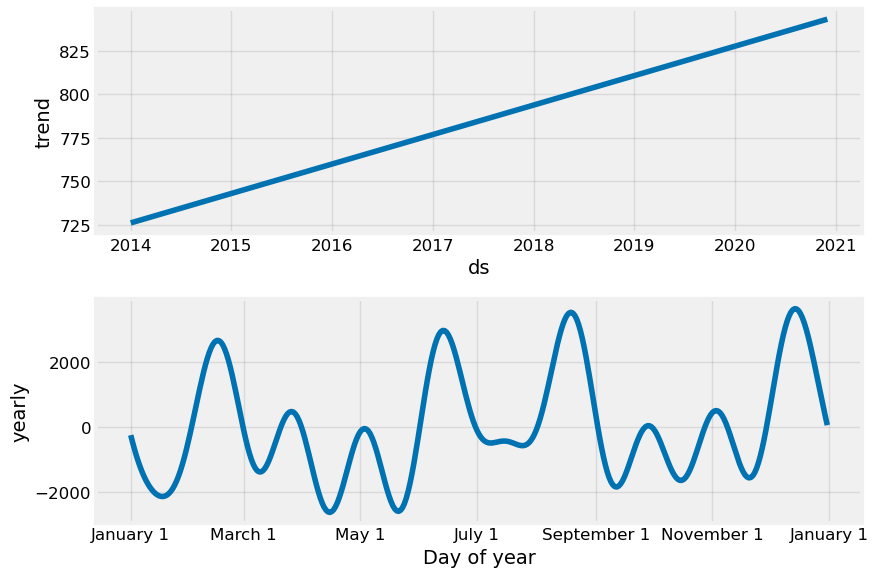

In [43]:
#now, we can use the Prophet Models to inspect different trends of these two categories in the data.

furniture_model.plot_components(furniture_forecast);

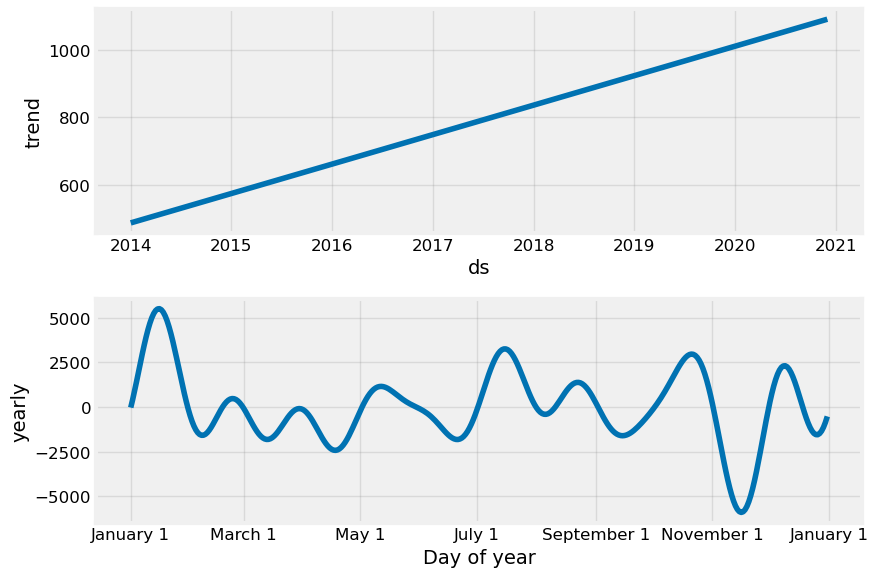

In [44]:
office_model.plot_components(office_forecast);

# SUMMARY 

Although office supplies’ growth seems slightly stronger, the sales for both furniture and office supplies linearly increase over time and will keep growing.

The worst month for furniture is April.
The worst month for office supplies is February.
The best month for furniture is December.
The best month for office supplies is October.